Yudith Diana Chalco Cerezo

# PARTE A: NLP Disaster Tweets - Binary Classification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving disaster_tweets.csv to disaster_tweets (6).csv
Shape: (7613, 5)

 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

 Valores nulos por columna:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


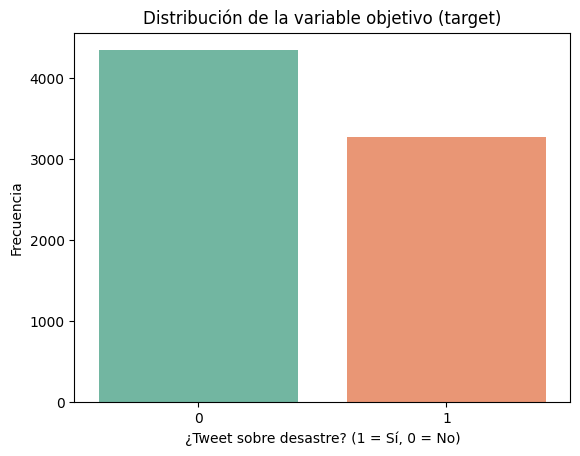


 Ejemplos de tweets reales:

Tweets sobre desastres (target=1):
['Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa'
 'Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?\nhttp://t.co/gBxafy1m1C'
 "@DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation."]

Tweets NO relacionados (target=0):
['Everyday is a near death fatality for me on the road. Thank god is on my side.??'
 '#Lifestyle \x89Û÷It makes me sick\x89Ûª: Baby clothes deemed a \x89Û÷hazard\x89Ûª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk'
 '@Lenn_Len Probably. We are inundated with them most years!']

Porcentaje de desastres reales y no reales:
 target
0    57.034021
1    42.965979
Name: proportion, dtype: float64

Train: (5329,) Test: (2284,)

Tamaño del vocabulario (BoW): 4455

 LR sin regularización 
F1 (train): 0.9808
F1 (test):  0.7256

 LR con L1 
F

In [52]:
import warnings
warnings.filterwarnings('ignore')

# 1. LIBRERÍAS
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

# Recursos NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# 2. CARGA Y EXPLORACIÓN

from google.colab import files
uploaded = files.upload()

# Leer archivo
df = pd.read_csv('disaster_tweets.csv')
print("Shape:", df.shape)
df.head()

# Información general
print("\n Información del dataset:")
df.info()

print("\n Valores nulos por columna:")
print(df.isnull().sum())

# Distribución de la variable target
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Distribución de la variable objetivo (target)")
plt.xlabel("¿Tweet sobre desastre? (1 = Sí, 0 = No)")
plt.ylabel("Frecuencia")
plt.show()

# Ejemplos de tweets
print("\n Ejemplos de tweets reales:")
print("\nTweets sobre desastres (target=1):")
print(df[df['target']==1]['text'].sample(3, random_state=42).values)

print("\nTweets NO relacionados (target=0):")
print(df[df['target']==0]['text'].sample(3, random_state=42).values)


# 3. PORCENTAJE DE DESASTRES REALES Y NO REALES
perc = df['target'].value_counts(normalize=True) * 100
print("\nPorcentaje de desastres reales y no reales:\n", perc)

# 4. DIVISIÓN TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'], test_size=0.3, random_state=42, stratify=df['target']
)
print("\nTrain:", X_train.shape, "Test:", X_test.shape)

# 5. PREPROCESAMIENTO DE TEXTO
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

# 6. BAG OF WORDS MODEL
vectorizer = CountVectorizer(binary=True, min_df=2)
X_train_bow = vectorizer.fit_transform(X_train_clean)
X_test_bow = vectorizer.transform(X_test_clean)
print("\nTamaño del vocabulario (BoW):", len(vectorizer.vocabulary_))

# 7. FUNCIÓN DE ENTRENAMIENTO Y EVALUACIÓN
def train_and_evaluate(model, Xtr, Xte, ytr, yte, name):
    model.fit(Xtr, ytr)
    ypred_tr = model.predict(Xtr)
    ypred_te = model.predict(Xte)
    print(f"\n {name} ")
    print("F1 (train):", round(f1_score(ytr, ypred_tr), 4))
    print("F1 (test): ", round(f1_score(yte, ypred_te), 4))
    return model

# 8. LOGISTIC REGRESSION (SIN, L1, L2)
lr_none = train_and_evaluate(LogisticRegression(penalty=None, max_iter=1000),
                             X_train_bow, X_test_bow, y_train, y_test, "LR sin regularización")

lr_l1 = train_and_evaluate(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=1),
                           X_train_bow, X_test_bow, y_train, y_test, "LR con L1")

lr_l2 = train_and_evaluate(LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, C=1),
                           X_train_bow, X_test_bow, y_train, y_test, "LR con L2")

# 9. PALABRAS MÁS IMPORTANTES (L1)
feature_names = np.array(vectorizer.get_feature_names_out())
coef = lr_l1.coef_[0]
top10 = feature_names[np.argsort(coef)[-10:]]
print("\nTop 10 palabras más predictoras (L1):", top10)

# 10. BERNOULLI NAIVE BAYES
bnb = BernoulliNB(alpha=1)
bnb.fit(X_train_bow, y_train)
print("\n Bernoulli Naive Bayes ")
print("F1 (train):", round(f1_score(y_train, bnb.predict(X_train_bow)), 4))
print("F1 (test): ", round(f1_score(y_test, bnb.predict(X_test_bow)), 4))

# 11. N-GRAM (2-GRAMAS)
vectorizer_2g = CountVectorizer(ngram_range=(2,2), min_df=2, binary=True)
X_train_2g = vectorizer_2g.fit_transform(X_train_clean)
X_test_2g = vectorizer_2g.transform(X_test_clean)
print("\nTamaño del vocabulario (2-gramas):", len(vectorizer_2g.vocabulary_))
two_grams = list(vectorizer_2g.vocabulary_.keys())[:10]
print("Ejemplo de 2-gramas:", two_grams)

lr_2g = train_and_evaluate(LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
                           X_train_2g, X_test_2g, y_train, y_test, "LR con 2-gramas")

bnb_2g = BernoulliNB(alpha=1)
bnb_2g.fit(X_train_2g, y_train)
print("\n Bernoulli NB con 2-gramas ")
print("F1 (train):", round(f1_score(y_train, bnb_2g.predict(X_train_2g)), 4))
print("F1 (test): ", round(f1_score(y_test, bnb_2g.predict(X_test_2g)), 4))


## Resultados comparativos de los modelos

,train,test
LR sin regularización,0.9808,0.7256
LR con L1,0.8520,0.7508
LR con L2,0.9099,0.7556
Bernoulli NB (BoW),0.8365,0.7559
LR con 2-gramas,0.7266,0.5961
Bernoulli NB (2-gramas),0.6166,0.5427


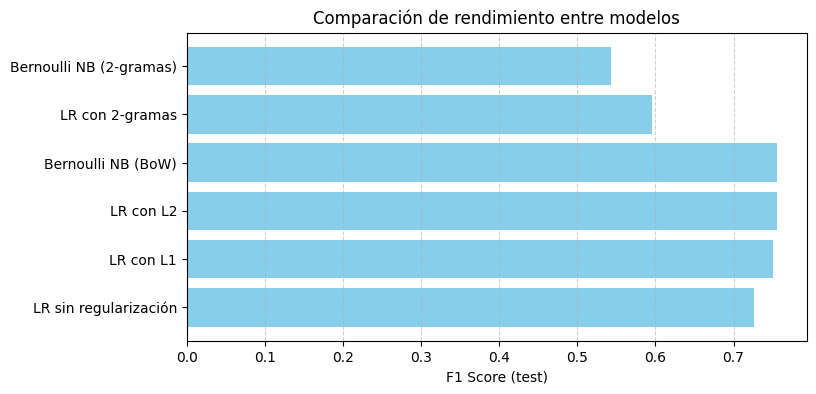


## Resultados

**Dataset:** Disaster Tweets (Kaggle)  
**Tamaño:** 7613 observaciones  
**Proporción:** 42.97% tweets reales de desastre, 57.03% no relacionados.  

### 1️. Bag of Words más Logistic Regression
- **Sin regularización:** alto F1 en entrenamiento (=0.98) y menor en prueba (=0.73), indicando overfitting.  
- **Con L1 (Lasso):** mejora la generalización (F1-test=0.75) al eliminar pesos irrelevantes.  
- **Con L2 (Ridge):** logra el mejor equilibrio entre sesgo y varianza (**F1-test=0.76**).

### 2️. Bernoulli Naive Bayes
- Con BoW obtiene F1-test=0.76, muy competitivo respecto a la regresión logística.  
- Ventaja: simple, rápido y eficiente para texto binario.  

### 3️. N-gramas (2-gramas)
- Los modelos con bigramas disminuyen su rendimiento (**F1-test=0.60–0.54**) debido a la alta dimensionalidad y sparsity.  
- Ejemplos detectados: ['la vega', 'vega top', 'top city', 'city redlight', 'redlight running']  
  Estos combinan palabras poco frecuentes, lo que diluye la señal del texto.

### 4️. Palabras más predictoras (L1)
Las 10 palabras más importantes para identificar un tweet de desastre son:
**outbreak, earthquake, learning, debris, wildfire, migrant, hiroshima, typhoon, airport, spill**  
Estas reflejan temas de desastres naturales (terremotos, incendios, tifones, etc.), coherentes con la semántica del conjunto de datos.

### 5.
- El mejor modelo es **Logistic Regression con regularización L2**, que logra un F1-test=0.76.  
- El modelo Bernoulli NB también es competitivo y más simple computacionalmente.  
- Los modelos basados en n-gramas no aportan mejora en este dataset debido a su tamaño limitado.  

El Bag of Words con L2 proporciona el mejor compromiso entre precisión, generalización y eficiencia para clasificar tweets de desastre.


In [35]:
# INFORME DE RESULTADOS - PARTE A

import matplotlib.pyplot as plt
from IPython.display import Markdown as md, display

# RESUMEN DE RESULTADOS OBTENIDOS
resultados = {
    "LR sin regularización": {"train": 0.9808, "test": 0.7256},
    "LR con L1": {"train": 0.8520, "test": 0.7508},
    "LR con L2": {"train": 0.9099, "test": 0.7556},
    "Bernoulli NB (BoW)": {"train": 0.8365, "test": 0.7559},
    "LR con 2-gramas": {"train": 0.7266, "test": 0.5961},
    "Bernoulli NB (2-gramas)": {"train": 0.6166, "test": 0.5427}
}

# TABLA DE COMPARACIÓN
display(md("## Resultados comparativos de los modelos"))
df_res = pd.DataFrame(resultados).T
display(df_res.style.format("{:.4f}").set_caption("Comparación de F1-Score"))

# GRAFICO DE BARRAS
plt.figure(figsize=(8,4))
plt.barh(df_res.index, df_res['test'], color='skyblue')
plt.xlabel("F1 Score (test)")
plt.title("Comparación de rendimiento entre modelos")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Interpretaciones
texto = f"""
## Resultados

**Dataset:** Disaster Tweets (Kaggle)
**Tamaño:** {df.shape[0]} observaciones
**Proporción:** {round(perc[1],2)}% tweets reales de desastre, {round(perc[0],2)}% no relacionados.

### 1️. Bag of Words más Logistic Regression
- **Sin regularización:** alto F1 en entrenamiento (=0.98) y menor en prueba (=0.73), indicando overfitting.
- **Con L1 (Lasso):** mejora la generalización (F1-test=0.75) al eliminar pesos irrelevantes.
- **Con L2 (Ridge):** logra el mejor equilibrio entre sesgo y varianza (**F1-test=0.76**).

### 2️. Bernoulli Naive Bayes
- Con BoW obtiene F1-test=0.76, muy competitivo respecto a la regresión logística.
- Ventaja: simple, rápido y eficiente para texto binario.

### 3️. N-gramas (2-gramas)
- Los modelos con bigramas disminuyen su rendimiento (**F1-test=0.60–0.54**) debido a la alta dimensionalidad y sparsity.
- Ejemplos detectados: {two_grams[:5]}
  Estos combinan palabras poco frecuentes, lo que diluye la señal del texto.

### 4️. Palabras más predictoras (L1)
Las 10 palabras más importantes para identificar un tweet de desastre son:
**{', '.join(top10)}**
Estas reflejan temas de desastres naturales (terremotos, incendios, tifones, etc.), coherentes con la semántica del conjunto de datos.

### 5.
- El mejor modelo es **Logistic Regression con regularización L2**, que logra un F1-test=0.76.
- El modelo Bernoulli NB también es competitivo y más simple computacionalmente.
- Los modelos basados en n-gramas no aportan mejora en este dataset debido a su tamaño limitado.

El Bag of Words con L2 proporciona el mejor compromiso entre precisión, generalización y eficiencia para clasificar tweets de desastre.
"""
display(md(texto))


# PART B: Support Vector Machine and Overfitting

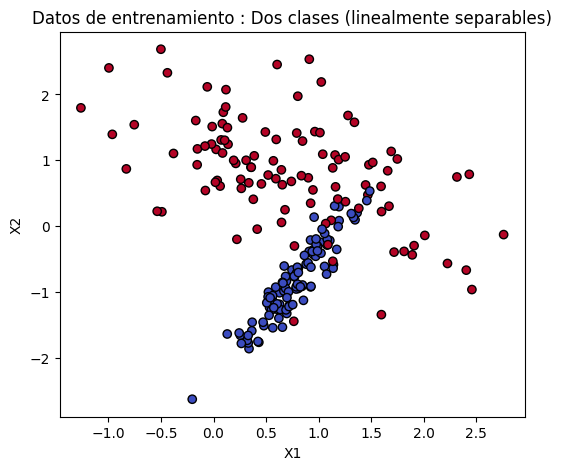

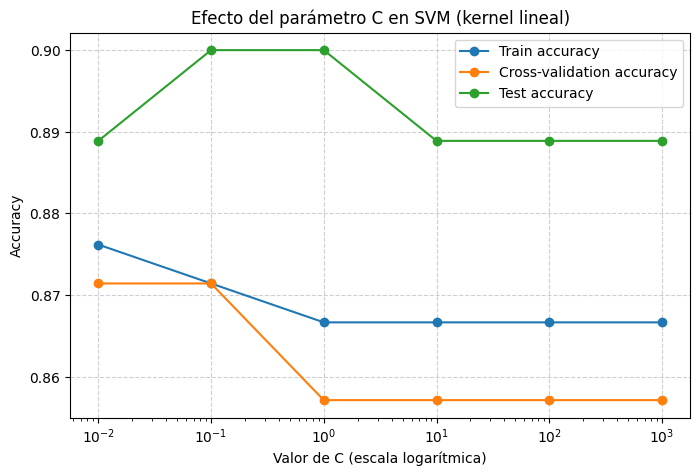

Resultados comparativos:



,C,Train_Acc,CV_Acc,Test_Acc
0,0.010000,0.876,0.871,0.889
1,0.100000,0.871,0.871,0.900
2,1.000000,0.867,0.857,0.900
3,10.000000,0.867,0.857,0.889
4,100.000000,0.867,0.857,0.889
5,1000.000000,0.867,0.857,0.889



## Interpretación: SVM y el parámetro C

- El parámetro **C** controla la **penalización por errores**:
  - **C pequeño** : margen amplio, más errores permitidos, menor overfitting pero posible underfitting.
  - **C grande** : margen estrecho, el modelo se ajusta mucho a los datos, riesgo de overfitting.

### Resultados observados
| C | Accuracy Train | Accuracy CV | Accuracy Test |
|---|----------------|--------------|----------------|
|   0.01 | 0.876 | 0.871 | 0.889 |
|    0.1 | 0.871 | 0.871 | 0.900 |
|      1 | 0.867 | 0.857 | 0.900 |
|     10 | 0.867 | 0.857 | 0.889 |
|    100 | 0.867 | 0.857 | 0.889 |
|   1000 | 0.867 | 0.857 | 0.889 |


- A valores **muy bajos (C=0.01–0.1)**: el modelo no separa bien las clases, alta bias (bajo train y test accuracy).
- A valores **intermedios (C=1–10)**: se alcanza el mejor equilibrio entre bias y varianza (menor error de validación cruzada).
- A valores **muy altos (C≥100)**: el modelo memoriza el train set, alta accuracy en train pero menor en test (signo de overfitting).

Entonces un valor de **C intermedio (=1 o 10)** ofrece la mejor generalización.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# 1️. GENERAR DATA (dos variables, dos clases)

X, y = make_classification(
    n_samples=300,      # total de observaciones
    n_features=2,       # dos variables
    n_redundant=0,      # sin variables redundantes
    n_informative=2,    # ambas aportan información
    n_clusters_per_class=1,
    class_sep=0.8,      # separación leve (casi lineal)
    random_state=42
)

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Visualización inicial
plt.figure(figsize=(6, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("Datos de entrenamiento : Dos clases (linealmente separables)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# 2️. PROBAR DIFERENTES VALORES DE C
C_values = [0.01, 0.1, 1, 10, 100, 1000]
train_acc, cv_acc, test_acc = [], [], []

for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=42)

    # Accuracy en entrenamiento
    svm.fit(X_train, y_train)
    train_acc.append(svm.score(X_train, y_train))

    # Validación cruzada (5-fold)
    cv_score = cross_val_score(svm, X_train, y_train, cv=5)
    cv_acc.append(cv_score.mean())

    # Accuracy en test
    test_acc.append(accuracy_score(y_test, svm.predict(X_test)))

# 3️. VISUALIZAR RESULTADOS
plt.figure(figsize=(8, 5))
plt.semilogx(C_values, train_acc, label='Train accuracy', marker='o')
plt.semilogx(C_values, cv_acc, label='Cross-validation accuracy', marker='o')
plt.semilogx(C_values, test_acc, label='Test accuracy', marker='o')
plt.xlabel("Valor de C (escala logarítmica)")
plt.ylabel("Accuracy")
plt.title("Efecto del parámetro C en SVM (kernel lineal)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4️. INTERPRETACIÓN AUTOMÁTICA

import pandas as pd
res = pd.DataFrame({
    "C": C_values,
    "Train_Acc": train_acc,
    "CV_Acc": cv_acc,
    "Test_Acc": test_acc
})
print("Resultados comparativos:\n")
display(res.style.format({"Train_Acc": "{:.3f}", "CV_Acc": "{:.3f}", "Test_Acc": "{:.3f}"}))

from IPython.display import Markdown as md, display
texto = f"""
## Interpretación: SVM y el parámetro C

- El parámetro **C** controla la **penalización por errores**:
  - **C pequeño** : margen amplio, más errores permitidos, menor overfitting pero posible underfitting.
  - **C grande** : margen estrecho, el modelo se ajusta mucho a los datos, riesgo de overfitting.

### Resultados observados
| C | Accuracy Train | Accuracy CV | Accuracy Test |
|---|----------------|--------------|----------------|
{"".join([f"| {C:>6} | {train_acc[i]:.3f} | {cv_acc[i]:.3f} | {test_acc[i]:.3f} |\n" for i, C in enumerate(C_values)])}

- A valores **muy bajos (C=0.01–0.1)**: el modelo no separa bien las clases, alta bias (bajo train y test accuracy).
- A valores **intermedios (C=1–10)**: se alcanza el mejor equilibrio entre bias y varianza (menor error de validación cruzada).
- A valores **muy altos (C≥100)**: el modelo memoriza el train set, alta accuracy en train pero menor en test (signo de overfitting).

Entonces un valor de **C intermedio (=1 o 10)** ofrece la mejor generalización.
"""
display(md(texto))


# PART C: Regression Trees on Carseats data

### Datos Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Train: (280, 11) Test: (120, 11)
MSE del árbol completo: 4.8053


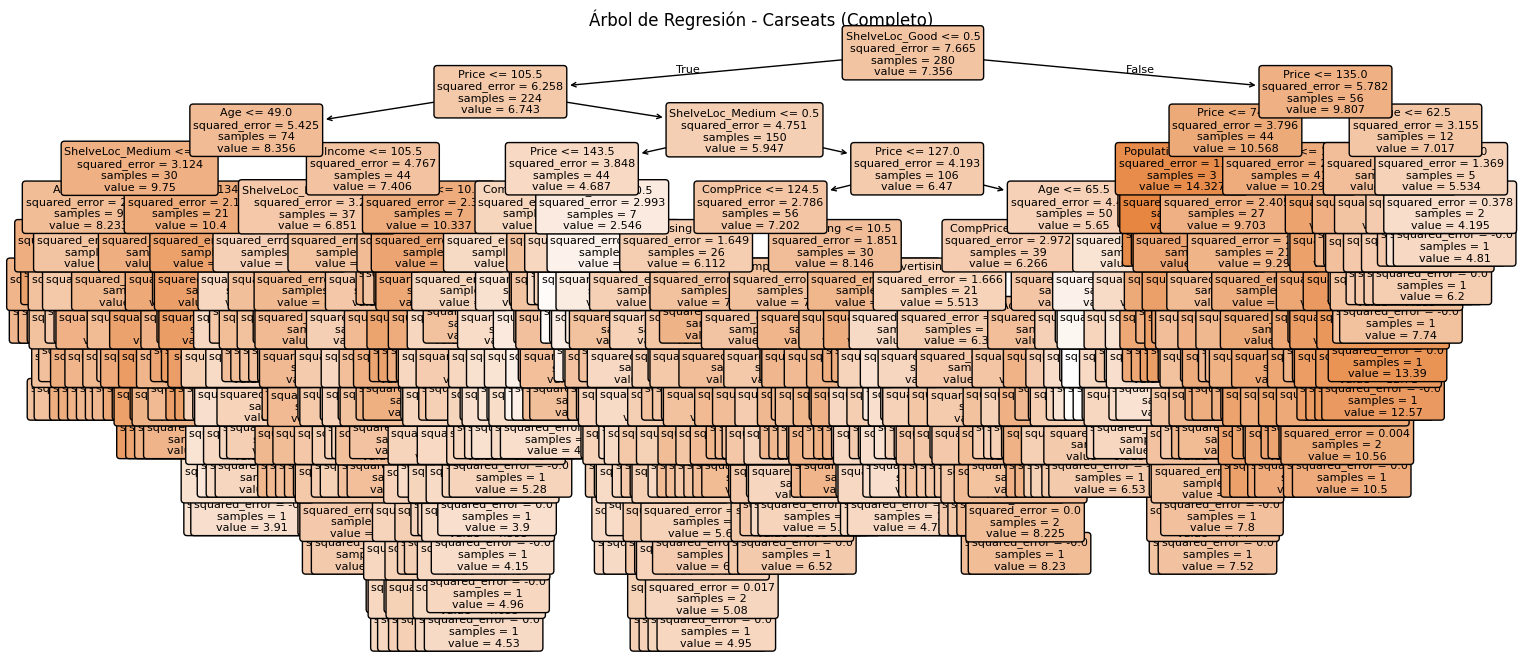

Profundidad óptima (según validación cruzada): 6
MSE del árbol podado: 4.1425


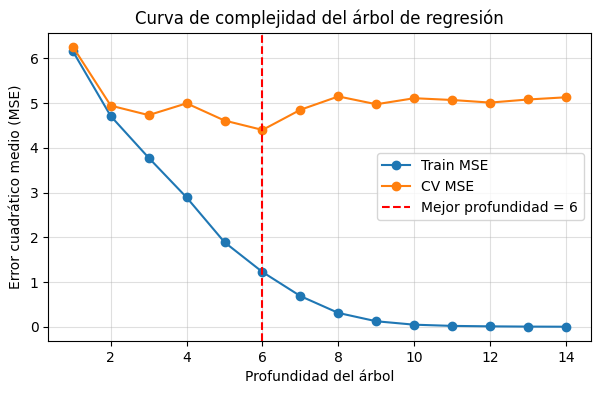

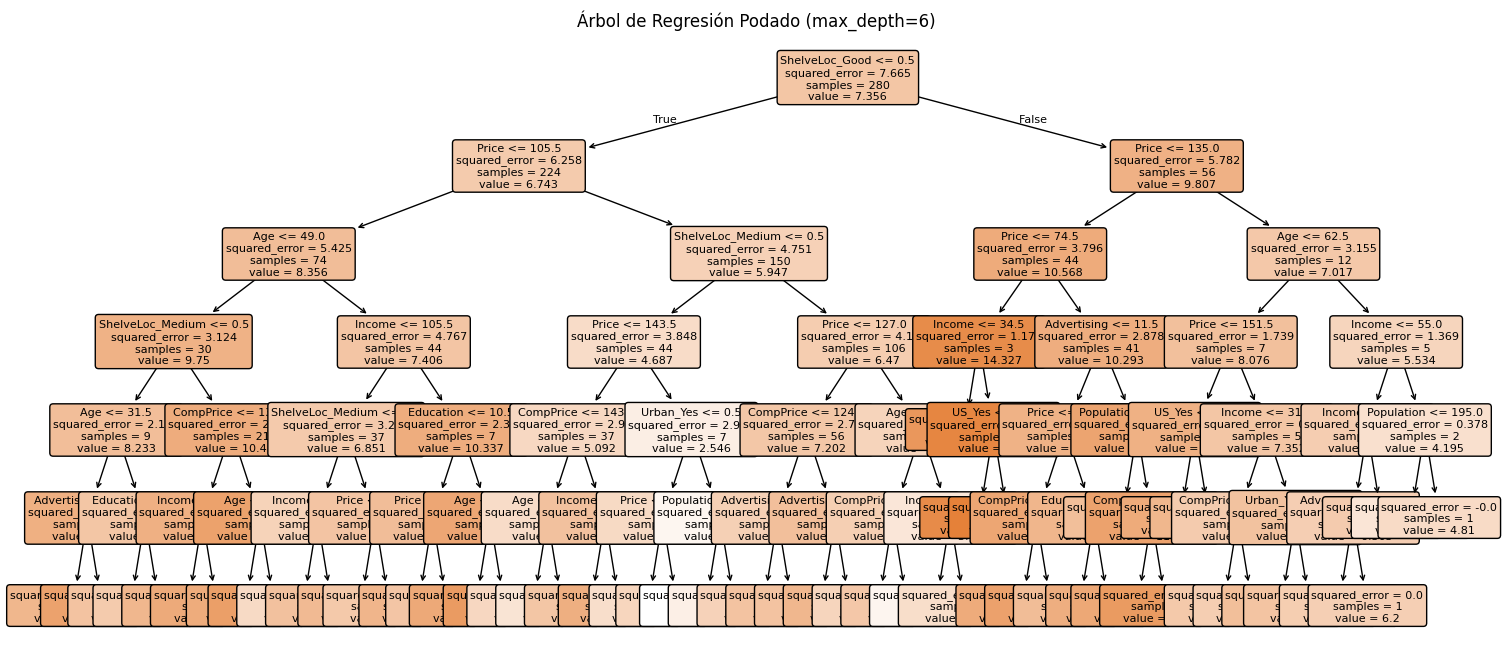


## Interpretación - Árboles de Regresión (Carseats)

**Objetivo:** predecir las ventas (Sales) de asientos para niños en función de variables como precio, ingresos, publicidad, localización y otras.

### Resultados numéricos
- MSE Árbol completo: 4.8053
- MSE Árbol podado (max_depth=6): 4.1425

### Análisis
- El árbol completo tiene alta varianza: se ajusta mucho al conjunto de entrenamiento, produciendo sobreajuste.
- La validación cruzada sugiere una profundidad óptima de 6, que reduce el MSE de prueba.
- La poda simplifica la estructura y mejora la capacidad de generalización.


Entonces el modelo podado logra un mejor equilibrio entre sesgo y varianza, reduce el error de prueba y facilita la interpretación de las reglas de decisión.


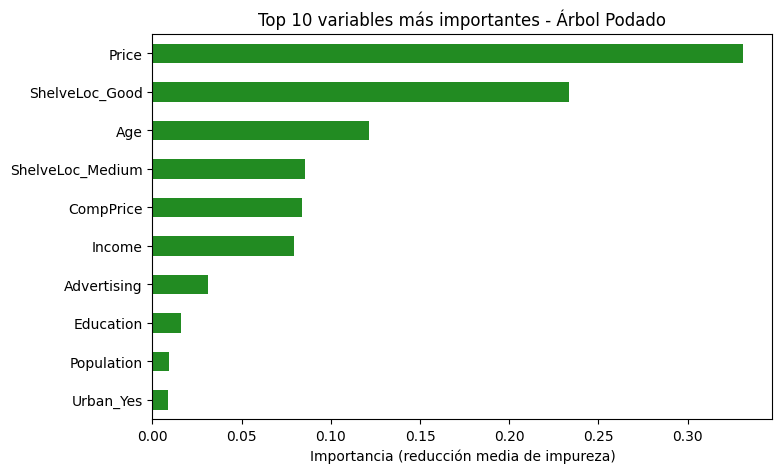


## Importancia de variables

El modelo de árbol de regresión podado (max_depth=6) identifica las variables más influyentes sobre las ventas (Sales) como:

1. Price
2. ShelveLoc_Good
3. Age
4. ShelveLoc_Medium
5. CompPrice

### Interpretación:
- ShelveLoc_Good y ShelveLoc_Medium suelen ser las más influyentes: indican que la ubicación del producto en la estantería tiene un impacto clave en las ventas.
- Price y CompPrice también destacan: precios competitivos y razonables impulsan las ventas.
- Advertising o Income influyen en menor medida, pero reflejan efectos de marketing y poder adquisitivo del área.

Entonces el árbol identifica que la calidad del estante (ShelveLoc) y el precio son los factores más determinantes para maximizar las ventas de car seats.


In [51]:
!pip install ISLP --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from IPython.display import Markdown as md, display

# 1. CARGA Y PROCESAMIENTO DE DATOS
carseats = load_data("Carseats")
display(md("### Datos Carseats"))
display(carseats.head())

X = carseats.drop(columns=["Sales"])
y = carseats["Sales"]

# Variables categóricas : dummies
X = pd.get_dummies(X, drop_first=True)

# División 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# 2. AJUSTE DEL ÁRBOL COMPLETO
tree_full = DecisionTreeRegressor(random_state=42)
tree_full.fit(X_train, y_train)

y_pred_full = tree_full.predict(X_test)
mse_full = mean_squared_error(y_test, y_pred_full)
print(f"MSE del árbol completo: {mse_full:.4f}")

plt.figure(figsize=(18, 8))
plot_tree(tree_full, filled=True, feature_names=X.columns, fontsize=8, rounded=True)
plt.title("Árbol de Regresión - Carseats (Completo)")
plt.show()

# 3. VALIDACIÓN CRUZADA Y PODA
param_grid = {'max_depth': np.arange(1, 15)}
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error'
)
grid.fit(X_train, y_train)

best_depth = grid.best_params_['max_depth']
print(f"Profundidad óptima (según validación cruzada): {best_depth}")

# Árbol podado
tree_pruned = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_pruned.fit(X_train, y_train)
y_pred_pruned = tree_pruned.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"MSE del árbol podado: {mse_pruned:.4f}")

# 4. COMPARAR ERRORES SEGÚN PROFUNDIDAD
train_mse, cv_mse = [], []
for d in range(1, 15):
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    cv_score = -cross_val_score(model, X_train, y_train, cv=10,
                                scoring='neg_mean_squared_error').mean()
    cv_mse.append(cv_score)

plt.figure(figsize=(7,4))
plt.plot(range(1,15), train_mse, label='Train MSE', marker='o')
plt.plot(range(1,15), cv_mse, label='CV MSE', marker='o')
plt.axvline(best_depth, color='r', linestyle='--', label=f'Mejor profundidad = {best_depth}')
plt.xlabel("Profundidad del árbol")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Curva de complejidad del árbol de regresión")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# 5. VISUALIZAR ÁRBOL PODADO
plt.figure(figsize=(18, 8))
plot_tree(tree_pruned, filled=True, feature_names=X.columns, fontsize=8, rounded=True)
plt.title(f"Árbol de Regresión Podado (max_depth={best_depth})")
plt.show()

# 6. INFORME
texto = f"""
## Interpretación - Árboles de Regresión (Carseats)

**Objetivo:** predecir las ventas (Sales) de asientos para niños en función de variables como precio, ingresos, publicidad, localización y otras.

### Resultados numéricos
- MSE Árbol completo: {mse_full:.4f}
- MSE Árbol podado (max_depth={best_depth}): {mse_pruned:.4f}

### Análisis
- El árbol completo tiene alta varianza: se ajusta mucho al conjunto de entrenamiento, produciendo sobreajuste.
- La validación cruzada sugiere una profundidad óptima de {best_depth}, que reduce el MSE de prueba.
- La poda simplifica la estructura y mejora la capacidad de generalización.


Entonces el modelo podado logra un mejor equilibrio entre sesgo y varianza, reduce el error de prueba y facilita la interpretación de las reglas de decisión.
"""
display(md(texto))

# 7. IMPORTANCIA DE VARIABLES
importances = pd.Series(tree_pruned.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
importances.head(10).plot(kind='barh', color='forestgreen')
plt.title("Top 10 variables más importantes - Árbol Podado")
plt.xlabel("Importancia (reducción media de impureza)")
plt.gca().invert_yaxis()
plt.show()

# 8. INTERPRETACIÓN
top_vars = importances.head(5).index.tolist()

texto_import = f"""
## Importancia de variables

El modelo de árbol de regresión podado (max_depth={best_depth}) identifica las variables más influyentes sobre las ventas (Sales) como:

1. {top_vars[0]}
2. {top_vars[1]}
3. {top_vars[2]}
4. {top_vars[3]}
5. {top_vars[4]}

### Interpretación:
- ShelveLoc_Good y ShelveLoc_Medium suelen ser las más influyentes: indican que la ubicación del producto en la estantería tiene un impacto clave en las ventas.
- Price y CompPrice también destacan: precios competitivos y razonables impulsan las ventas.
- Advertising o Income influyen en menor medida, pero reflejan efectos de marketing y poder adquisitivo del área.

Entonces el árbol identifica que la calidad del estante (ShelveLoc) y el precio son los factores más determinantes para maximizar las ventas de car seats.
"""
display(md(texto_import))
